##  Importing Libraries

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode (connected=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

##  Loading Dataset

In [97]:
df=pd.read_csv('Covid-19_Dataset.csv')

In [98]:
df.head(2)

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link
0,765,15.0,02-10-20,new confirmed COVID-19 patient in Vietnam: 3 m...,Vinh Phuc,Vietnam,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,Vietnam News,https://vietnamnews.vn/society/591803/viet-nam...
1,477,27.0,02-05-20,new confirmed COVID-19 patient in Singapore: m...,Singapore,Singapore,male,0.50,NaN,NaN,NaN,1/23/2020,02-03-20,0,0,0,1,NaN,Straits Times,https://www.straitstimes.com/singapore/health/...


In [99]:
df.shape

(1085, 20)

In [100]:
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan                 int64
death                      int64
recovered                  int64
symptom                   object
source                    object
link                      object
dtype: object

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   summary                1080 non-null   object 
 4   location               1085 non-null   object 
 5   country                1085 non-null   object 
 6   gender                 902 non-null    object 
 7   age                    843 non-null    float64
 8   symptom_onset          563 non-null    object 
 9   If_onset_approximated  560 non-null    float64
 10  hosp_visit_date        507 non-null    object 
 11  exposure_start         128 non-null    object 
 12  exposure_end           341 non-null    object 
 13  visiting Wuhan         1085 non-null   int64  
 14  from Wuhan             1085 non-null   int64  
 15  deat

##  Data Cleaning

First we remove unnecessary columns.

In [102]:
df.drop(['id','case_in_country','summary','symptom_onset', 'If_onset_approximated', 'hosp_visit_date', 'exposure_start',
'exposure_end', 'symptom', 'source', 'link'],axis=1,inplace=True)

In [103]:
100*df.isnull().sum()/df.shape[0]

reporting date     0.092166
location           0.000000
country            0.000000
gender            16.866359
age               22.304147
visiting Wuhan     0.000000
from Wuhan         0.000000
death              0.000000
recovered          0.000000
dtype: float64

In [104]:
df['age']= df['age']. fillna(df['age'].mean())

In [105]:
df_dum=pd.get_dummies(df['gender'].dropna(), drop_first=True)

In [106]:
df_dum['male'].median()

1.0

So we fill the null values in gender column with 'male'.

In [107]:
df['gender']= df['gender']. fillna('male')

Fianlly the columns that contain less than 0.5% null values are remained, and we drop the rows of df that contain these null values.

In [108]:
df.dropna(inplace=True)

In [109]:
df.isnull().sum()

reporting date    0
location          0
country           0
gender            0
age               0
visiting Wuhan    0
from Wuhan        0
death             0
recovered         0
dtype: int64

##  Feature Engineering

We rename some of the columns.

In [110]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add month column to df.

In [111]:
df['reporting_date']=pd.to_datetime(df['reporting_date'])

In [112]:
df['year']=df['reporting_date'].apply(lambda x:x.year)
df['month']=df['reporting_date'].apply(lambda x:x.month)

In [113]:
df['month'].unique()

array([2, 1], dtype=int64)

As there is only one year, we can remove the year column.

In [114]:
df.drop(['reporting_date', 'year'], axis=1, inplace=True)

In [115]:
df.head(2)

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2
1,Singapore,Singapore,male,0.50,0,0,0,1,2


##  Exploratory Data Analysis

We want to find the number of patients died and recovered based on their age.

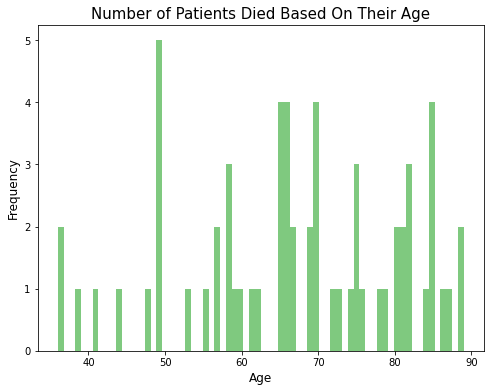

In [116]:
plt.figure(figsize=(8,6))
df[df['death']==1]['age'].plot(kind='hist',bins=70,colormap='Accent')
plt.title('Number of Patients Died Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

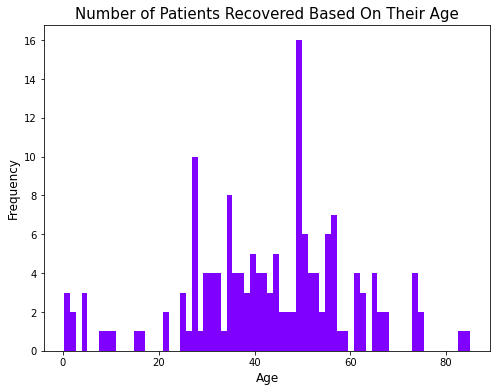

In [117]:
plt.figure(figsize=(8,6))
df[df['recovered']==1]['age'].plot(kind='hist',bins=70,colormap='rainbow')
plt.title('Number of Patients Recovered Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

In [118]:
print('Current count of patients:',df['death'].count())
print('Number of Dead Patients:', df[df['death']==1]['death'].count())
print('Number of Recovered Patients:',df[df['recovered']==1]['death'].count())
print('Number of Patients Receiving Treatment:',df[(df['death']==0)&(df['recovered']==0)]['death'].count())

Current count of patients: 1084
Number of Dead Patients: 63
Number of Recovered Patients: 159
Number of Patients Receiving Treatment: 862


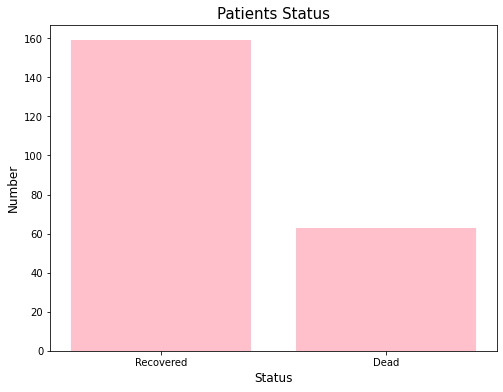

In [119]:
plt.figure(figsize=(8,6))
plt.bar(x=['Recovered','Dead'],height=[159,63], color='pink')
plt.title('Patients Status',fontsize=15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.show()

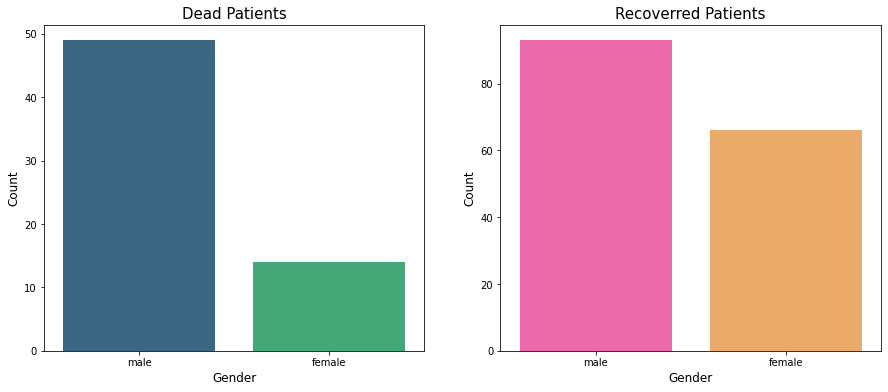

In [120]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='gender', data=df[df['death']==1], palette='viridis')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='gender', data=df[df['recovered']==1], palette='spring')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

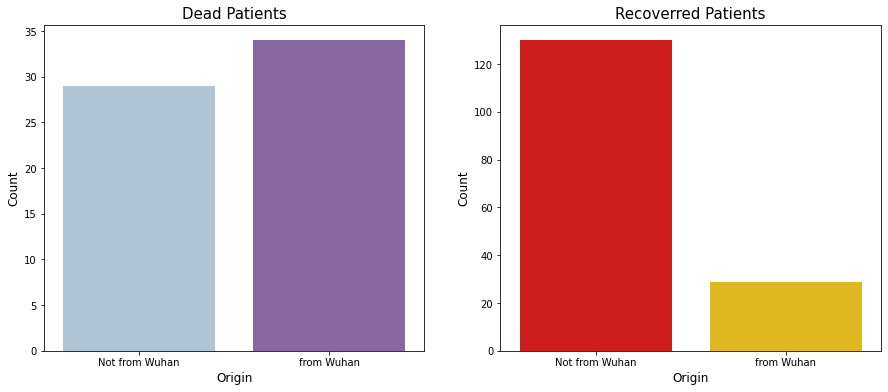

In [121]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='from_wuhan', data=df[df['death']==1], palette='BuPu')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='from_wuhan', data=df[df['recovered']==1], palette='hot')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

In [122]:
country_order=list(df.groupby('country').count()['location'].sort_values(ascending=False).index)

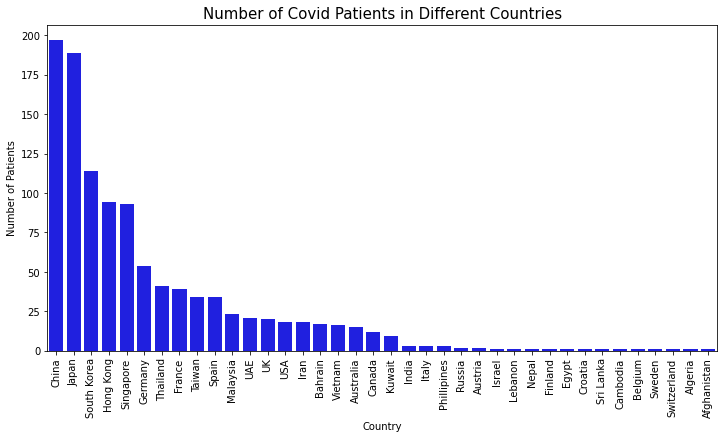

In [123]:
plt.figure(figsize=(12,6))
sns.countplot(x='country',data=df,color='blue',order=country_order)
plt.xticks(rotation=90)
plt.ylabel('Number of Patients')
plt.xlabel('Country')
plt.title('Number of Covid Patients in Different Countries',fontsize=15)
plt.show()

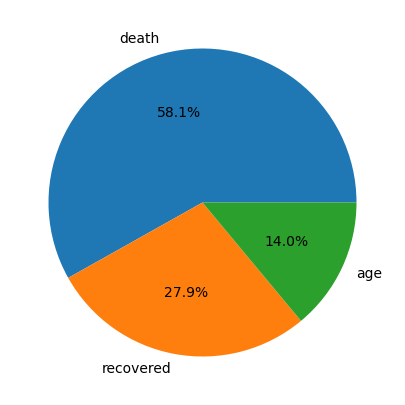

In [163]:
labels = ["death","recovered","age"]
values = [500,240,120]

f,ax = plt.subplots(figsize=(10, 5))
plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.show()

In [124]:
groupby_df=df.groupby('country').sum()

##  Prediction of Death or Recovery of Patients

### Label Encoding

**Location**

In [125]:
le1=LabelEncoder()
le1.fit(df['location'])
df['location']=le1.transform(df['location'])

**Country**

In [126]:
le2=LabelEncoder()
le2.fit(df['country'])
df['country']=le2.transform(df['country'])

**Gender**

In [127]:
le3=LabelEncoder()
le3.fit(df['gender'])
df['gender']=le3.transform(df['gender'])

In [128]:
df.head()

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,141,37,1,0.25,0,0,0,1,2
1,118,26,1,0.50,0,0,0,1,2
2,118,26,1,1.00,0,0,0,1,2
3,42,8,0,2.00,1,0,0,0,1
4,60,22,1,2.00,0,0,0,1,1


###  Predicting the Recovery

####  Splitting the Data

In [129]:
y=df['recovered']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####  Random Forest Classifier

In [131]:
rfc1=RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train,y_train)
predictions_rfc1=rfc1.predict(X_test)

In [132]:
print(confusion_matrix(y_test,predictions_rfc1))
print('\n')
print(classification_report(y_test,predictions_rfc1))

[[178   7]
 [ 12  20]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       185
           1       0.74      0.62      0.68        32

    accuracy                           0.91       217
   macro avg       0.84      0.79      0.81       217
weighted avg       0.91      0.91      0.91       217



In [133]:
rf_recovery_acc = accuracy_score(y_test,predictions_rfc1)
rf_recovery_acc

0.9124423963133641

####  Support Vector Classifier

In [134]:
svc1=SVC()
svc1.fit(X_train,y_train)
predictions_svc1=svc1.predict(X_test)

In [135]:
print(confusion_matrix(y_test,predictions_svc1))
print('\n')
print(classification_report(y_test,predictions_svc1))

[[185   0]
 [ 32   0]]


              precision    recall  f1-score   support

           0       0.85      1.00      0.92       185
           1       0.00      0.00      0.00        32

    accuracy                           0.85       217
   macro avg       0.43      0.50      0.46       217
weighted avg       0.73      0.85      0.78       217



To improve the results obtained by SVC, we define C and gamma parameters.

In [136]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}

In [137]:
gs1=GridSearchCV(SVC(),param_grid, verbose=3)
gs1.fit(X_train,y_train)
predictions_gs1=gs1.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.851, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.851, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.855, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.851, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.851, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.851, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.856, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.833, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.855, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.867, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.850, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.851, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.862, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


In [138]:
print(confusion_matrix(y_test,predictions_gs1))
print('\n')
print(classification_report(y_test,predictions_gs1))

[[182   3]
 [ 26   6]]


              precision    recall  f1-score   support

           0       0.88      0.98      0.93       185
           1       0.67      0.19      0.29        32

    accuracy                           0.87       217
   macro avg       0.77      0.59      0.61       217
weighted avg       0.84      0.87      0.83       217



In [139]:
svr_recovery_acc = accuracy_score(y_test,predictions_gs1)
svr_recovery_acc

0.8663594470046083

####  XGBoost Classifier

In [140]:
xgbc1=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc1.fit(X_train,y_train)

[08:29:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
predictions_xgbc1=xgbc1.predict(X_test)

In [142]:
print(confusion_matrix(y_test,predictions_xgbc1))
print('\n')
print(classification_report(y_test,predictions_xgbc1))

[[180   5]
 [ 11  21]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       185
           1       0.81      0.66      0.72        32

    accuracy                           0.93       217
   macro avg       0.88      0.81      0.84       217
weighted avg       0.92      0.93      0.92       217



In [143]:
xg_recovery_acc = accuracy_score(y_test,predictions_xgbc1)
xg_recovery_acc

0.9262672811059908

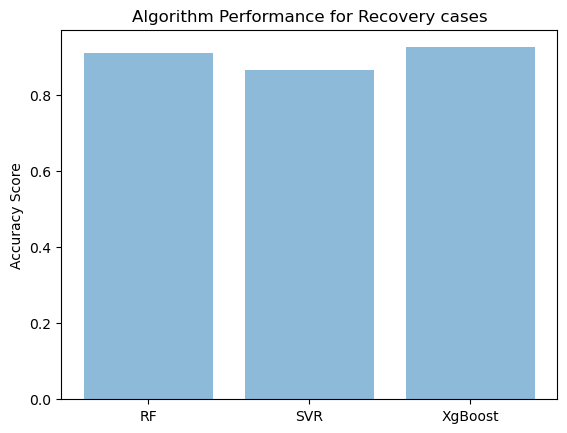

In [144]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('RF','SVR','XgBoost')
y_pos = np.arange(len(objects))
performance = [rf_recovery_acc,svr_recovery_acc,xg_recovery_acc]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy Score')
plt.title('Algorithm Performance for Recovery cases')

plt.show()

###  Predicting the Death

#### Splitting the Data

In [145]:
y=df['death']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110)

####  Random Forest Classifier

In [147]:
rfc2=RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train,y_train)
predictions_rfc2=rfc2.predict(X_test)

In [148]:
print(confusion_matrix(y_test,predictions_rfc2))
print('\n')
print(classification_report(y_test,predictions_rfc2))

[[202   1]
 [  9   5]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       203
           1       0.83      0.36      0.50        14

    accuracy                           0.95       217
   macro avg       0.90      0.68      0.74       217
weighted avg       0.95      0.95      0.95       217



In [149]:
rf_death_acc = accuracy_score(y_test,predictions_rfc2)
rf_death_acc

0.9539170506912442

#### Support Vector Classifier

In [150]:
svc2=SVC()
svc2.fit(X_train,y_train)
predictions_svc2=svc2.predict(X_test)

In [151]:
print(confusion_matrix(y_test,predictions_svc2))
print('\n')
print(classification_report(y_test,predictions_svc2))

[[203   0]
 [ 14   0]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       203
           1       0.00      0.00      0.00        14

    accuracy                           0.94       217
   macro avg       0.47      0.50      0.48       217
weighted avg       0.88      0.94      0.90       217



To improve the results obtained by SVC, we define C and gamma parameters.

In [152]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}

In [153]:
gs2=GridSearchCV(SVC(),param_grid, verbose=3)
gs2.fit(X_train,y_train)
predictions_gs2=gs2.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.943, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.948, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.942, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.942, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.943, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.943, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.948, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.942, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.942, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.943, total=   0.0s
[CV] C

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.960, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.948, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.983, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.971, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.971, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.965, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.948, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [154]:
print(confusion_matrix(y_test,predictions_gs2))
print('\n')
print(classification_report(y_test,predictions_gs2))

[[203   0]
 [  8   6]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       203
           1       1.00      0.43      0.60        14

    accuracy                           0.96       217
   macro avg       0.98      0.71      0.79       217
weighted avg       0.96      0.96      0.96       217



In [155]:
svr_death_acc = accuracy_score(y_test,predictions_gs2)
svr_death_acc

0.9631336405529954

####  XGBoost Classifier

In [156]:
xgbc2=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc2.fit(X_train,y_train)

[08:29:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
predictions_xgbc2=xgbc2.predict(X_test)

In [158]:
print(confusion_matrix(y_test,predictions_xgbc2))
print('\n')
print(classification_report(y_test,predictions_xgbc2))

[[203   0]
 [  9   5]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       203
           1       1.00      0.36      0.53        14

    accuracy                           0.96       217
   macro avg       0.98      0.68      0.75       217
weighted avg       0.96      0.96      0.95       217



In [159]:
xg_death_acc = accuracy_score(y_test,predictions_xgbc2)
xg_death_acc

0.9585253456221198

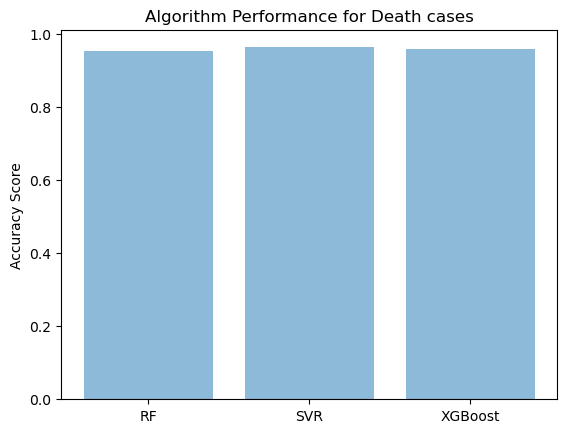

In [160]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('RF','SVR','XGBoost')
y_pos = np.arange(len(objects))
performance = [rf_death_acc,svr_death_acc,xg_death_acc]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy Score')
plt.title('Algorithm Performance for Death cases')

plt.show()